In [41]:
from datasets import load_dataset

emotions = load_dataset("emotion")
print(emotions)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [42]:
import pandas as pd

emotions.set_format(type='pandas')
df = emotions['train'][:]
print(df.head())

                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3


In [43]:
# Add labelname to the dataset
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df['labelname'] = df['label'].apply(label_int2str)
print(df.head())

                                                text  label labelname
0                            i didnt feel humiliated      0   sadness
1  i can go from feeling so hopeless to so damned...      0   sadness
2   im grabbing a minute to post i feel greedy wrong      3     anger
3  i am ever feeling nostalgic about the fireplac...      2      love
4                               i am feeling grouchy      3     anger


1. Dataexploring mithilfe von Pandas und Matplotlib

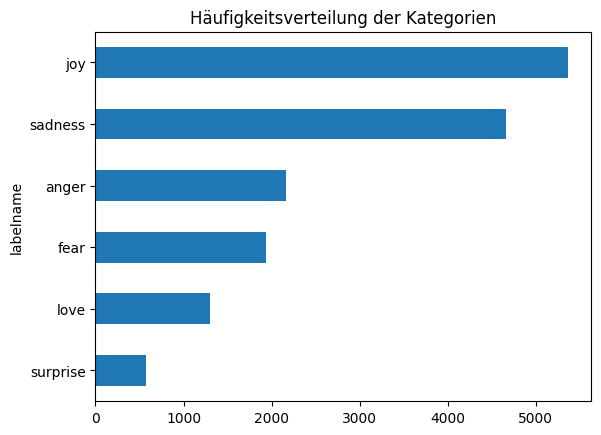

In [44]:
import matplotlib.pyplot as plt

df['labelname'].value_counts(ascending=True).plot.barh()
plt.title('Häufigkeitsverteilung der Kategorien')
plt.show()

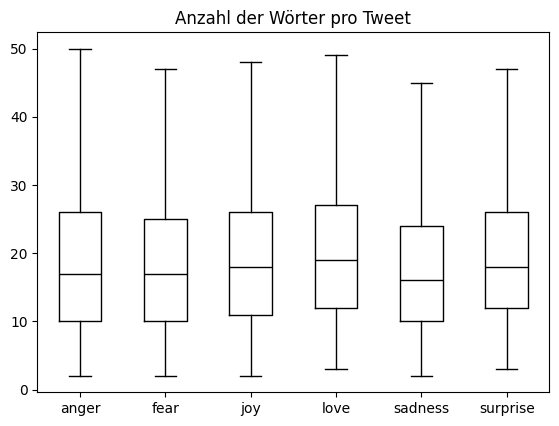

In [45]:
# Wie lange sind unsere Tweets?
df["Anzahl der Wörter pro Tweet"] = df['text'].str.split().apply(len)
df.boxplot("Anzahl der Wörter pro Tweet", by="labelname", grid=False, showfliers=False, color="black")
plt.suptitle('')
plt.xlabel("")
plt.show()

Die Länge der Tweets liegt bei ~15 Wörtern je Emotion. Selbst die längsten Tweets liegen unter der maximalen Kontextlänge von DistilBERT. Das bedeutet es ist eine Kürzung notwendig. Im folgenden konvertieren wir nun die Rohtexte in ein Format, dass sich für die Transformer-Bibliothek eignet. DataFrame-Format wird auch zurück gesetzt, da es nicht mehr benötigt wird. 

In [46]:
# Zurücksetzen des DataFormats
emotions.reset_format()

Vom Text zu Tokens: 

In [47]:
from transformers import AutoTokenizer

# Laden des Tokenizers
# DistilBERT ist ein vortrainiertes Modell, das wir für unser Sentiment Analysis Modell verwenden
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [48]:
# Sehen wir uns an, wie der Tokenizer funktioniert
text = "Tokenizing text is a core task of NLP."
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [49]:
# Nachdem wir nun die input_ids vorliegen haben, können wir sie wieder in Tokens konvertieren:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [50]:
# So bringen wir mit dem AutoTokenizer unsere tokens zurück in eine Zeichenkette: 
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


VORSICHT! Wenn ich ein vortrainiertes Modell nutze, dann muss ich darauf achten den gleichen Tokenizer zu verwenden, der auch beim Training verwendet wurde. Aus Sicht des Modells ist ein Wechsel des Tokenizers wie eine Umstellung des Vokabulars. 

In [51]:
# Bearbeitungsfunktion um die Texte zu tokenisieren
def tokenize_function(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

print(tokenize_function(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [52]:
# Map-Methode: Anwenden der Tokenisierungsfunktion auf das gesamte Dataset
emotions_encoded = emotions.map(tokenize_function, batched=True, batch_size=None)
print(emotions_encoded['train'].column_names)

['text', 'label', 'input_ids', 'attention_mask']


Transformermodelle als Feature Extraktoren. 
Mit dieser Methode frieren wir die Gewichtung des Bodys während des Trainings ein und verwenden die verborgenen Zustände als Features für den Klassifikator. 

In [53]:
from transformers import AutoModel
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [54]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Shape des Eingabe-Tensors: {inputs['input_ids'].size()}")

Shape des Eingabe-Tensors: torch.Size([1, 6])


In [55]:
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


In [56]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [57]:
def extract_hidden_states(batch):
    # Modelleingaben auf der GPU platzieren
    inputs = {k: v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    # Letzte verborgene Zustände extrahieren
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Vektor für [CLS] Token zurückgeben
    return {"hidden state": last_hidden_state[:, 0].cpu().numpy()}
    

In [58]:
emotions_encoded.set_format(type='torch',
                             columns=['input_ids', 'attention_mask', 'label'])

emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden state']

In [59]:
# Erstellen der Feature Matrix
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden state"])
X_valid = np.array(emotions_hidden["validation"]["hidden state"])
Y_train = np.array(emotions_hidden["train"]["label"])
Y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

/var/folders/kt/0951cp5901jfqvm_wv2pg1800000gn/T/ipykernel_67946/665721088.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  X_train = np.array(emotions_hidden["train"]["hidden state"])
/var/folders/kt/0951cp5901jfqvm_wv2pg1800000gn/T/ipykernel_67946/665721088.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  X_valid = np.array(emotions_hidden["validation"]["hidden state"])
/var/folders/kt/0951cp5901jfqvm_wv2pg1800000gn/T/ipykernel_67946/665721088.py:6: DeprecationWarni

((16000, 768), (2000, 768))

In [62]:
# Trainieren eines Klassifikators
from sklearn.linear_model import LogisticRegression

# Wir erhöhen 'max_iter' , um sicherzustellen, dass das Modell konvergiert
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, Y_train)
lr_clf.score(X_valid, Y_valid)


0.634

Genauigkeit = 63% (Klassifikator auf DistilBERT-Embeddings). Prüfen wir im folgenden mit der DummyClassifier-Klasse ein Baseline Modell.

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, Y_train)
dummy_clf.score(X_valid, Y_valid)
    

0.352

Genauigkeit des baseline modells liegt bei 35%. Das zeigt dass das Modell basierend auf DistilBERT bereits besser abschneidet. 

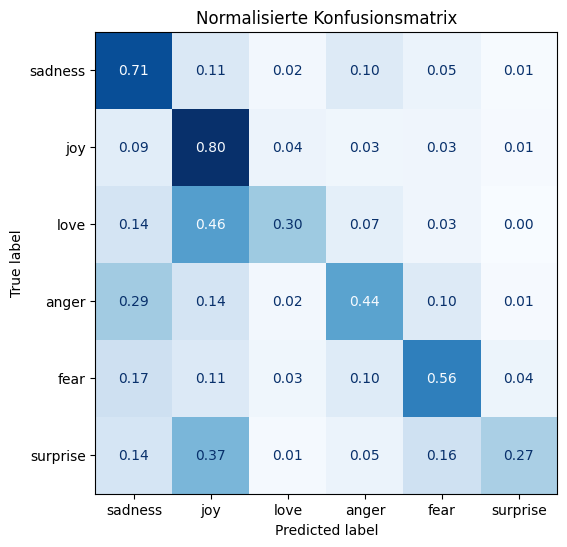

In [64]:
# Leistung des Modells besser untersuchen, mit einer Konfusionsmatrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fiq, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalisierte Konfusionsmatrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
labels = emotions["train"].features["label"].names
plot_confusion_matrix(y_preds, Y_valid, labels)

Es zeigt sich dass das Model häufig "anger" und "fear" mit "sadness" und "love" und "surprise" mit "joy" verwechselt.